In [19]:
import numpy as np 
import pandas as pd

import re
import string
import os

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ramakanth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
df_train = pd.read_csv("C:/Users/ramakanth/Downloads/labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
df_test=pd.read_csv("C:/Users/ramakanth/Downloads/testData.tsv", header=0, delimiter="\t", quoting=3)

In [21]:
df_train.head()

id  sentiment                                             review
0  "5814_8"          1  "With all this stuff going down at the moment ...
1  "2381_9"          1  "\"The Classic War of the Worlds\" by Timothy ...
2  "7759_3"          0  "The film starts with a manager (Nicholas Bell...
3  "3630_4"          0  "It must be assumed that those who praised thi...
4  "9495_8"          1  "Superbly trashy and wondrously unpretentious ...

In [22]:
df_test.head()

id                                             review
0  "12311_10"  "Naturally in a film who's main themes are of ...
1    "8348_2"  "This movie is a disaster within a disaster fi...
2    "5828_4"  "All in all, this is a movie for kids. We saw ...
3    "7186_2"  "Afraid of the Dark left me with the impressio...
4   "12128_7"  "A very accurate depiction of small time mob l...

In [23]:
def data_cleaning(raw_data):
    raw_data = raw_data.translate(str.maketrans('', '', string.punctuation + string.digits))
    words = raw_data.lower().split()
    stop_words = set(stopwords.words("english"))
    useful_words = [w for w in words if not w in stop_words]
    return " ".join(useful_words)

df_train['review'] = df_train['review'].apply(data_cleaning)
df_test['review'] = df_test['review'].apply(data_cleaning)


In [24]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

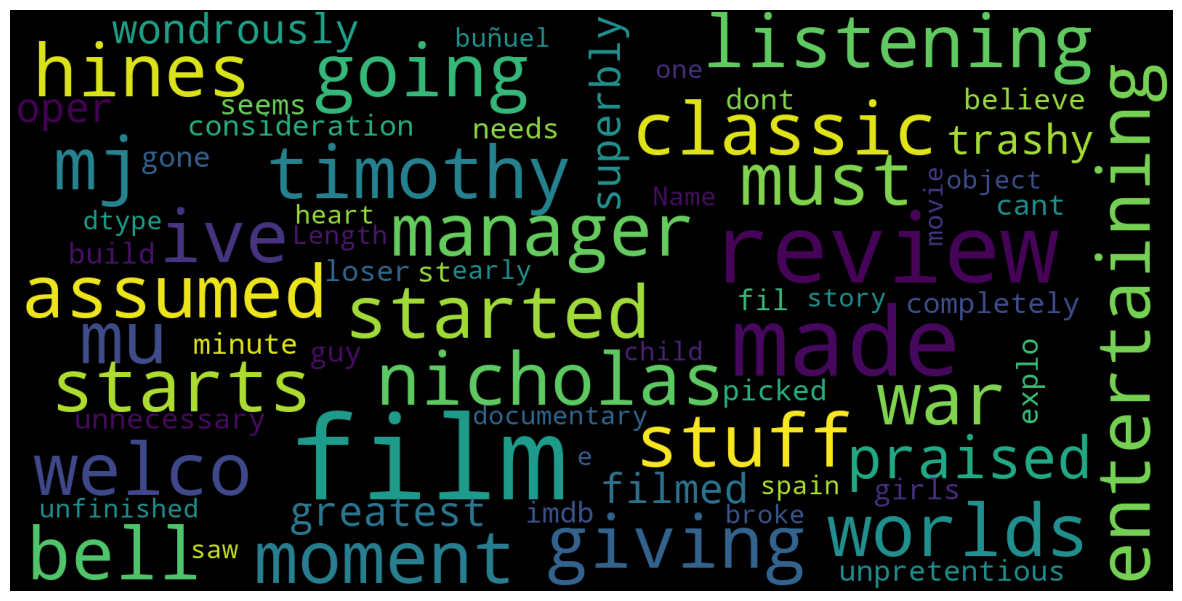

In [25]:
def generate_wordcloud(data, title = None):
    wordcloud = WordCloud(
        stopwords=stopwords,
        max_words=100,
        max_font_size=40, 
        scale=4).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

generate_wordcloud(df_train["review"])

In [26]:
print(df_train.isnull().sum())
print(df_test.isnull().sum())

id           0
sentiment    0
review       0
dtype: int64
id        0
review    0
dtype: int64


In [27]:
import tensorflow as tf
# from tensorflow import keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, SpatialDropout1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

In [28]:
y = df_train["sentiment"].values
train_reviews = df_train["review"]
test_reviews = df_test["review"]

In [29]:
max_features = 6000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_reviews))
list_tokenized_train = tokenizer.texts_to_sequences(train_reviews)
list_tokenized_test = tokenizer.texts_to_sequences(test_reviews)

In [30]:
max_length = 370
X_train = pad_sequences(list_tokenized_train, maxlen=max_length)
X_test = pad_sequences(list_tokenized_test, maxlen=max_length)

In [31]:
def tokenize(sentence):
  max_features = 6000
  tokenizer = Tokenizer(num_words=max_features)
  tokenizer.fit_on_texts(list(train_reviews))
  list_tokenized_test = tokenizer.texts_to_sequences(sentence)
  max_length = 360
  idv_test = pad_sequences(list_tokenized_test, maxlen=max_length)

  return idv_test

In [32]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epochs, logs={}):
        if logs.get('accuracy') > 0.95:
            print('\n Stopped Training!\n')
            self.model.stop_training = True

def train_model(model, model_name, n_epochs, batch_size, X_data, y_data, validation_split):    
    checkpoint_path = model_name+"_cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
    callbacks_earlystop = myCallback()
    history = model.fit(
        X_data,
        y_data,
        steps_per_epoch=batch_size,
        epochs=n_epochs,
        validation_split=validation_split,
        verbose=1,
        callbacks=[cp_callback, callbacks_earlystop]
    )
    return history

In [33]:
def generate_graph(history):
    plt.plot(history.history['accuracy'], 'b')
    plt.plot(history.history['val_accuracy'], 'r')
    plt.title('Model Accuracy'),
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [34]:
class Model_A():
    def __new__(self):
        inp = Input(shape=(max_length, ))
        embed_size = 128
        x = Embedding(max_features, embed_size)(inp)
        x = LSTM(60, return_sequences=True, name='lstm_layer')(x)
        x = GlobalMaxPool1D()(x)
        x = Dropout(0.1)(x)
        x = Dense(50, activation="relu")(x)
        x = Dropout(0.1)(x)
        x = Dense(1, activation="sigmoid")(x)
        model = Model(inputs=inp, outputs=x)
        model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])
        
        return model

model_a = Model_A()
     

In [35]:
print(model_a.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 370)]             0         
                                                                 
 embedding (Embedding)       (None, 370, 128)          768000    
                                                                 
 lstm_layer (LSTM)           (None, 370, 60)           45360     
                                                                 
 global_max_pooling1d (Globa  (None, 60)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 50)                3050      
                                                             

In [36]:
model_a = Model_A()
history_a = train_model(model_a, "model_a", 10, 64, X_train, y, 0.2)

Epoch 1/10
64/64 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5052
Epoch 1: saving model to model_a_cp-0001.ckpt
64/64 [==============================] - 114s 2s/step - loss: 0.6931 - accuracy: 0.5052 - val_loss: 0.6931 - val_accuracy: 0.5020
Epoch 2/10
64/64 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5007
Epoch 2: saving model to model_a_cp-0002.ckpt
64/64 [==============================] - 104s 2s/step - loss: 0.6932 - accuracy: 0.5007 - val_loss: 0.6931 - val_accuracy: 0.5038
Epoch 3/10
64/64 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5048
Epoch 3: saving model to model_a_cp-0003.ckpt
64/64 [==============================] - 114s 2s/step - loss: 0.6931 - accuracy: 0.5048 - val_loss: 0.6931 - val_accuracy: 0.5088
Epoch 4/10
64/64 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5067
Epoch 4: saving model to model_a_cp-0004.ckpt
64/64 [==============================] - 119s 2s/s

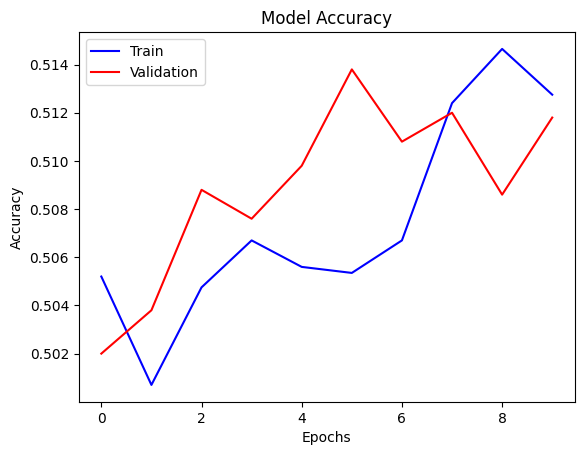

In [37]:
generate_graph(history_a)

In [ ]:
def predict_func(model):
  prediction = model.predict(X_test)
  y_pred = (prediction > 0.5)

  df_test["sentiment"] = df_test["id"].map(lambda x: 1 if int(x.strip('"').split("_")[1]) >= 5 else 0)
  y_test = df_test["sentiment"]

  cf_matrix = confusion_matrix(y_pred, y_test)
  f1_score_calc = cf_matrix[0][0] / (cf_matrix[0][0] + 0.5 * (cf_matrix[0][1] + cf_matrix[1][0]))
  print('F1-score: %.3f' % f1_score_calc)
  print("Confusion Matrix : ", cf_matrix)

  return f1_score_calc